In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
df_control = pd.read_csv("../data_files/clean/web_data_filtered_control.csv")
df_test = pd.read_csv("../data_files/clean/web_data_filtered_test.csv")

In [3]:
#function to drop values which list 'confirm', as there is no way to encounter an error at this step 
def remove_confirms(df):
    df_steps = df[df['process_step'] != 'confirm']
    return df_steps

In [4]:
df_control = remove_confirms(df_control)
df_test = remove_confirms(df_test)

In [5]:
def error_counts(df):
    grouped_counts = df.groupby('client_id')['process_step'].value_counts()
    adjusted_counts_df = grouped_counts.reset_index(name='error_count')
    adjusted_counts_df['error_count'] = adjusted_counts_df['error_count'] - 1
    adjusted_counts_df.columns = ['client_id', 'process_step', 'error_count']
    return adjusted_counts_df

In [6]:
df_control_error = error_counts(df_control)
df_test_error = error_counts(df_test)
df_control_error["variation"] = 'control'
df_test_error["variation"] = 'test'

In [7]:
df_control_error

,client_id,process_step,error_count,variation
0,1028,step_1,4,control
1,1028,step_2,1,control
2,1028,start,0,control
3,1028,step_3,0,control
4,1104,start,1,control
...,...,...,...,...
78849,9998346,step_2,3,control
78850,9998346,step_3,3,control
78851,9998346,step_1,1,control
78852,9998346,start,0,control


In [22]:
df_merged_error = pd.concat([df_test_error, df_control_error], axis=0, ignore_index=True)
df_merged_error.to_csv("df_error_rates.csv", encoding='utf-8', index=False)

PROCESS STEP BY ERROR COUNT

In [9]:
df_control_error_group1 = df_control_error.groupby("process_step")["error_count"].sum()
df_control_error_group1

process_step
start     24211
step_1     9319
step_2     7011
step_3     5188
Name: error_count, dtype: int64

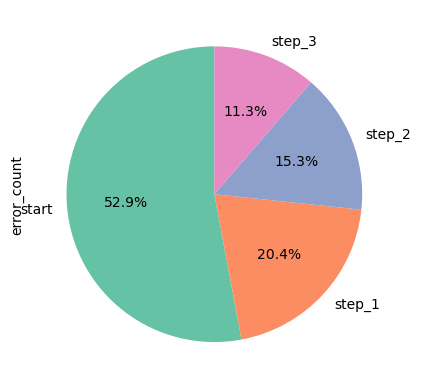

In [10]:
df_control_error_group1.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"));

In [11]:
df_test_error_group1 = df_test_error.groupby("process_step")["error_count"].sum()
df_test_error_group1

process_step
start     29795
step_1    14337
step_2     8560
step_3     4876
Name: error_count, dtype: int64

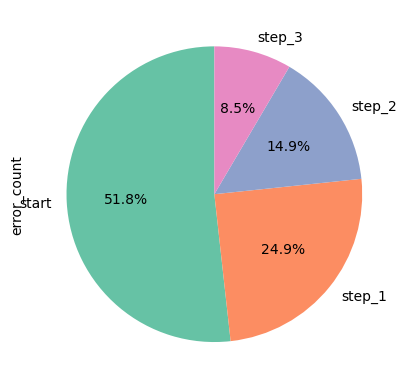

In [12]:
df_test_error_group1.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"));

AVERAGE ERROR RATES

In [13]:
df_control_error_group = df_control_error.groupby("client_id")["error_count"].sum()
df_control_error_group.describe()

count    23397.000000
mean         1.954481
std          3.571226
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         78.000000
Name: error_count, dtype: float64

In [14]:
df_test_error_group = df_test_error.groupby("client_id")["error_count"].sum()
df_test_error_group.describe()

count    26679.000000
mean         2.157802
std          3.759256
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         76.000000
Name: error_count, dtype: float64

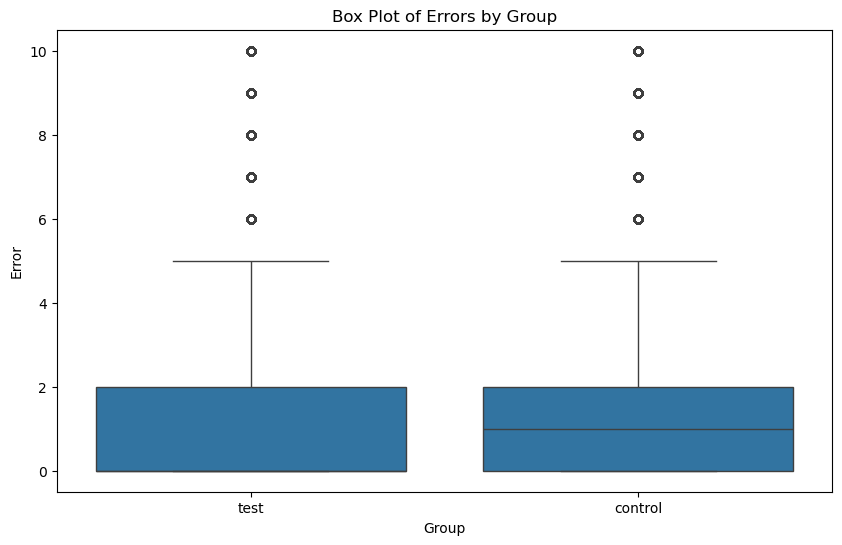

In [ ]:
error_count_total_merged = df_merged_error.groupby(['client_id', 'variation'])['error_count'].sum().reset_index()
error_count_total_merged.to_csv("error_count_total_merged.csv", encoding='utf-8', index=False)


C:\Users\MJ\AppData\Local\Temp\ipykernel_23860\2339312416.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



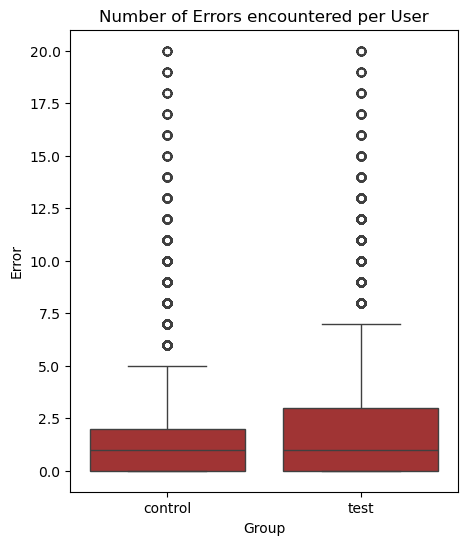

In [46]:

filtered_data = error_count_total_merged[error_count_total_merged['error_count'] <= 20]

filtered_data['variation'] = pd.Categorical(
    filtered_data['variation'], 
    categories=['control'] + [cat for cat in filtered_data['variation'].unique() if cat != 'control'],
    ordered=True
)
filtered_data = filtered_data.sort_values('variation')

# Create the box plot with red boxes
plt.figure(figsize=(5, 6))
sns.boxplot(data=filtered_data, x='variation', y='error_count', color='firebrick')
plt.title('Number of Errors encountered per User')
plt.xlabel('Group')
plt.ylabel('Error')
plt.show()

In [40]:
import plotly.express as px

# Ensure "control" appears first by sorting the data
filtered_data['variation'] = pd.Categorical(
    filtered_data['variation'], 
    categories=['control'] + [cat for cat in filtered_data['variation'].unique() if cat != 'control'],
    ordered=True
)
filtered_data = filtered_data.sort_values('variation')

# Create the Plotly box plot
fig = px.box(
    filtered_data, 
    x='variation', 
    y='error_count', 
    color_discrete_sequence=['red'],  # Set box color to red
    title='Box Plot of Errors by Group',
    labels={'variation': 'Group', 'error_count': 'Error'}  # Axis labels
)

# Show the plot
fig.show()


In [32]:
error_count_total_merged.head()

,client_id,variation,error_count
0,555,test,0
1,647,test,0
2,934,test,3
3,1028,control,5
4,1104,control,1


AVERAGE ERROR RATES, ADJUSTED FOR OUTLIERS

In [15]:
df_test_filtered = df_test_error[df_test_error["error_count"] <= 20]
df_control_filtered = df_control_error[df_control_error["error_count"] <= 20]

df_test_error_group1 = df_test_filtered.groupby("client_id")["error_count"].sum()
df_control_error_group1 = df_control_filtered.groupby("client_id")["error_count"].sum()


In [16]:
df_test_error_group1.describe()

count    26679.000000
mean         2.145433
std          3.661607
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         66.000000
Name: error_count, dtype: float64

In [ ]:
df_control_error_group1.describe()

count    23397.000000
mean         1.894474
std          3.181577
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         45.000000
Name: error_count, dtype: float64

In [27]:
df_control_error_group.mean()

1.9544813437620208

HYPOTHESIS TESTING, ERROR RATES

H0 = Average number of errors per user in the test group was equal to or greater than the control group

H1 = Average number of errors per user in the test group was less than the control group

In [18]:
error_test_mean = df_test_error_group.mean()
error_control_mean = df_control_error_group.mean()
